In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [123]:
import os
import shutil

import numpy as np 
import pandas as pd

import pydicom as dicom
import matplotlib.pyplot as plt

from pathlib import Path

In [124]:
train_dir = Path('E:\data\RSNA2024')

class CFG:
    random_seed = 42
    
    ROOT_FOLDER = train_dir
    IMAGES_DIR = ROOT_FOLDER / 'train_images'
    TRAIN_CSV = ROOT_FOLDER / 'train.csv'
    FILES_CSV = ROOT_FOLDER / 'train_files.csv'
    TRAIN_DESC_CSV = ROOT_FOLDER / 'train_series_descriptions.csv'
    COORDS_CSV = ROOT_FOLDER / 'train_label_coordinates.csv'


In [125]:
train_df = pd.read_csv(CFG.TRAIN_CSV)
train_desc_df = pd.read_csv(CFG.TRAIN_DESC_CSV)

coords_df = pd.read_csv(CFG.COORDS_CSV)
files_df = pd.read_csv(CFG.FILES_CSV)

coords_df.shape, files_df.shape, train_df.shape, train_desc_df.shape

((48692, 17), (147218, 17), (1975, 26), (6294, 3))

In [126]:
coords_df.sample(2)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc
2320,200354973,2579324362,8,SCS,L4L5,237.949458,279.317690,200354973_2579324362,200354973_2579324362_8,SCSL4L5,Sagittal T2/STIR,462,448,E:\data\RSNA2024\pngs_256\200354973_2579324362...,HFS,0.531137,0.604584
12282,1097875334,473318787,3,RSS,L1L2,266.835437,307.147436,1097875334_473318787,1097875334_473318787_3,RSSL1L2,Axial T2,576,576,E:\data\RSNA2024\pngs_256\1097875334_473318787...,FFS,0.463256,0.533242


### Condition positions on frame

In [127]:
coords_df.groupby('series_description').agg({'x_perc': ['min', 'max']})

x_perc          
                         min       max
series_description                    
Axial T2            0.284956  0.663196
Sagittal T1         0.208464  0.768467
Sagittal T2/STIR    0.004883  0.768142

In [128]:
coords_df.groupby('series_description').agg({'y_perc': ['min', 'max']})

y_perc          
                         min       max
series_description                    
Axial T2            0.309262  0.807810
Sagittal T1         0.107511  0.911765
Sagittal T2/STIR    0.004029  0.885110

In [129]:
coords_df.iloc[coords_df['y_perc'].argmin()]

study_id                                                     1820866003
series_id                                                     131094096
instance                                                              7
condition                                                           SCS
level                                                              L2L3
x                                                                   5.0
y                                                              2.063098
ss_id                                              1820866003_131094096
instance_id                                      1820866003_131094096_7
cl                                                              SCSL2L3
series_description                                     Sagittal T2/STIR
rows                                                                512
columns                                                             512
filename              E:\data\RSNA2024\pngs_256\1820866003_13109

### Plot condition

In [130]:
row = coords_df.iloc[coords_df['y_perc'].argmin()]

row['level']

'L2L3'

In [131]:
def plot(row, source=CFG.IMAGES_DIR):
    # filename = row['filename']

    filename = source / str(row['study_id']) / str(row['series_id']) / f'{row["instance"]}.dcm'

    conds = coords_df[coords_df['ss_id'] == row['ss_id']]

    print(row['study_id'])
    print(conds.x.to_list())
    print(conds.cl.to_list())
    print(conds.y.to_list())
    
    ds = dicom.dcmread(filename)
    img = ds.pixel_array

    # img = (img - img.min()) / (img.max() - img.min())

    if ds.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img

    plt.imshow(img, cmap="gray")
    
    # plt.scatter(row['x'], row['y'], marker="x", color="red", s=200)

    plt.title(row['series_description'] + f' - {row["instance"]}')

    plt.scatter(conds.x.to_list(), conds.y.to_list(), marker="x", color="red", s=200)
    
    plt.show()

#### Plot min x,y labels

4112621380
[255.7393075356416, 240.0977596741344, 239.0549898167006, 259.9103869653768, 251.56822810590631, 259.96571917808217, 247.06051369863013, 242.57174657534247, 245.93832191780825, 260.52681506849314]
['LNFNL5S1', 'LNFNL3L4', 'LNFNL4L5', 'LNFNL1L2', 'LNFNL2L3', 'RNFNL1L2', 'RNFNL2L3', 'RNFNL3L4', 'RNFNL4L5', 'RNFNL5S1']
[276.3340122199593, 175.18533604887983, 227.32382892057024, 65.69450101832994, 115.74745417515275, 55.045690282534245, 116.20514233732877, 172.31473137842465, 228.4243204195205, 278.3618546660959]


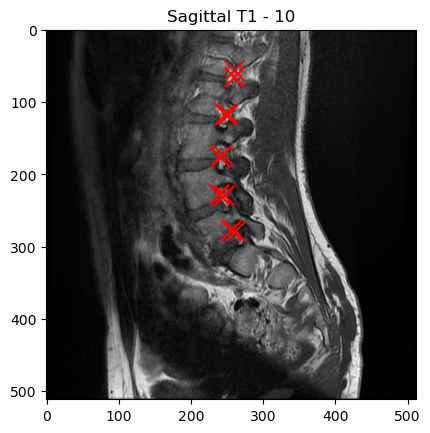

In [132]:
# bad labels
# bad_labels = [1820866003, 665627263, 2151509334, 1901348744, 286903519, 1880970480, 2151467507, 2905025904]

bad_labels = coords_df[coords_df['x'] < 10].study_id.tolist()

selection = coords_df[~coords_df['study_id'].isin(bad_labels)]
row = selection.iloc[selection['y_perc'].argmin()]

plot(row)

In [133]:
coords_df[coords_df['x'] < 10].shape, coords_df[coords_df['y'] < 10].shape

((13, 17), (13, 17))

#### Plot max x,y labels

2444340715
[212.0444763271162, 191.10903873744616, 239.0401721664276, 183.94691535150645, 215.35007173601147, 253.9175032939964, 232.44729247823096, 201.47387359647112, 187.3950468320348, 183.8753401409257]
['LNFNL2L3', 'LNFNL3L4', 'LNFNL1L2', 'LNFNL4L5', 'LNFNL5S1', 'RNFNL1L2', 'RNFNL2L3', 'RNFNL3L4', 'RNFNL4L5', 'RNFNL5S1']
[217.8938307030129, 263.6212338593974, 173.2682926829268, 302.7374461979914, 350.11764705882354, 136.85884509624196, 179.09532538955085, 214.2923923006416, 254.76901924839595, 300.5252062328139]


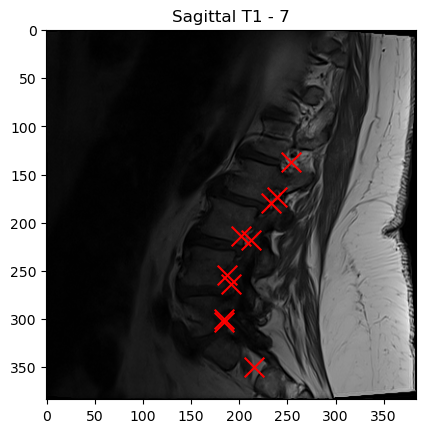

In [134]:
# bad labels
# bad_labels = [1820866003, 665627263, 2151509334, 1901348744, 286903519, 1880970480, 2151467507, 2905025904]

bad_labels = [3819260179]

# bad_labels = coords_df[coords_df['x'] < 10].study_id.tolist()

selection = coords_df[~coords_df['study_id'].isin(bad_labels)]
row = selection.iloc[selection['y_perc'].argmax()]

plot(row)

2444340715
[212.0444763271162, 191.10903873744616, 239.0401721664276, 183.94691535150645, 215.35007173601147, 253.9175032939964, 232.44729247823096, 201.47387359647112, 187.3950468320348, 183.8753401409257]
['LNFNL2L3', 'LNFNL3L4', 'LNFNL1L2', 'LNFNL4L5', 'LNFNL5S1', 'RNFNL1L2', 'RNFNL2L3', 'RNFNL3L4', 'RNFNL4L5', 'RNFNL5S1']
[217.8938307030129, 263.6212338593974, 173.2682926829268, 302.7374461979914, 350.11764705882354, 136.85884509624196, 179.09532538955085, 214.2923923006416, 254.76901924839595, 300.5252062328139]


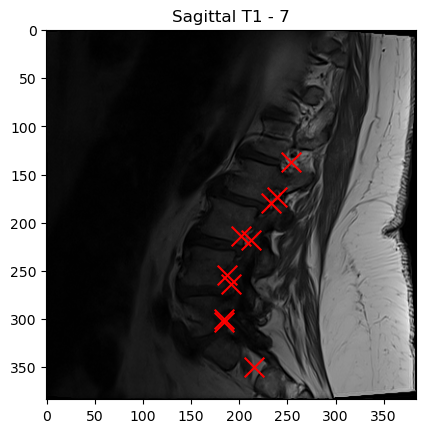

In [135]:
# bad labels
# bad_labels = [1820866003, 665627263, 2151509334, 1901348744, 286903519, 1880970480, 2151467507, 2905025904]

bad_labels = [3819260179]

# bad_labels = coords_df[coords_df['x'] < 10].study_id.tolist()

selection = coords_df[~coords_df['study_id'].isin(bad_labels)]
row = selection.iloc[selection['y_perc'].argmax()]

plot(row)

### Right/left orientation

<Axes: >

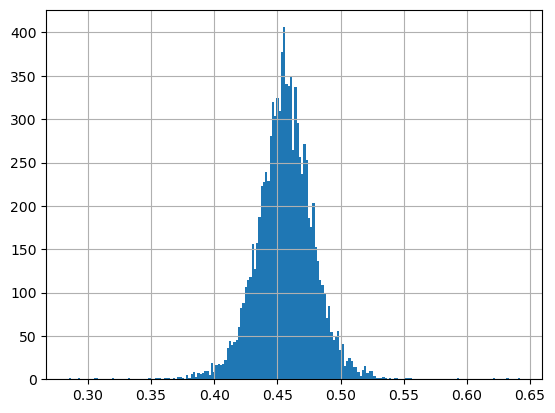

In [159]:
selection = coords_df[coords_df['condition'] == 'RSS']

selection.x_perc.hist(bins=200)

In [144]:
selection.patientposition.value_counts()

patientposition
HFS    7675
FFS    1937
Name: count, dtype: int64

In [145]:
selection[selection['x_perc'] > 0.50].patientposition.value_counts()

patientposition
HFS    196
FFS     59
Name: count, dtype: int64

In [146]:
selection[selection['x_perc'] < 0.45].patientposition.value_counts()

patientposition
HFS    2884
FFS     696
Name: count, dtype: int64

<Axes: >

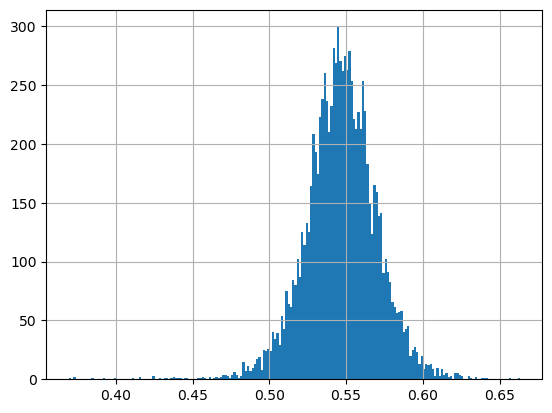

In [155]:
selection = coords_df[coords_df['condition'] == 'LSS']

selection.x_perc.hist(bins=200)

In [151]:
selection[selection['x_perc'] < 0.45].patientposition.value_counts()

patientposition
HFS    13
FFS    10
Name: count, dtype: int64

In [157]:
selection[selection['x_perc'] < 0.45].study_id.unique()

array([ 391103067,  677672203,  757619082, 1406734395, 1647904243,
       1670838975, 2399492744, 3495818564, 3945605592, 4072191052],
      dtype=int64)

### Frame positions in series

In [6]:
coords_df.sample(2)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,x_perc,y_perc
24275,2185340595,3336432860,11,LNFN,L1L2,295.495948,134.384040,2185340595_3336432860,2185340595_3336432860_11,LNFNL1L2,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2185340595_333643286...,0.577141,0.262469
47938,4224446605,2878505045,5,RNFN,L1L2,210.320334,119.799443,4224446605_2878505045,4224446605_2878505045_5,RNFNL1L2,Sagittal T1,384,384,E:\data\RSNA2024\pngs_256\4224446605_287850504...,0.547709,0.311978
